In [1]:
import sys
pathName = '../../em_examples/'
sys.path.append(pathName)
# from DCLayers import *
import SimPEG.Utils as Utils
from DCWidgetPlate2_5D import *
%matplotlib inline

# 1. Understanding currents, fields, charges and potentials

## Plate model

 - **A**: Electrode A (+) location
 - **B**: Electrode B (-) location
 - **dx**: width of plate
 - **dz**: height/thickness of plate
 - **xc**: x location of plate center
 - **zc**: z location of plate center
 - **rotAngle**: rotation angle of plate from the horizontal
 - **rhoplate**: Resistivity of the cylinder
 - **rhohalf**: Resistivity of the half-space
 - **Field**: Field to visualize
 - **Type**: which part of the field

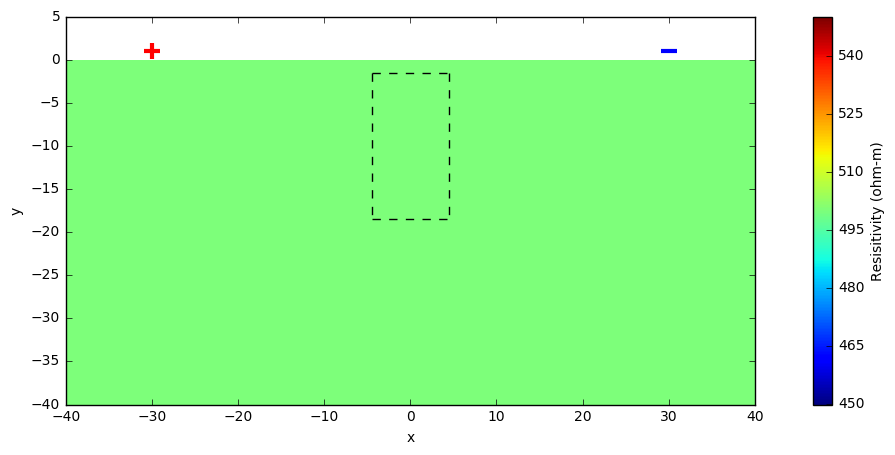

In [2]:
app = plate_app();
app

# 2. Potential differences and Apparent Resistivities

Using the widgets contained in this notebook you will develop a better understand of what values are actually measured in a DC resistivity survey and how these measurements can be processed, plotted, inverted, and interpreted.

# Computing Apparent Resistivity

In practice we cannot measure the potentials everywhere, we are limited to those locations where we place electrodes. For each source (current electrode pair) many potential differences are measured between M and N electrode pairs to characterize the overall distribution of potentials. The widget below allows you to visualize the potentials, electric fields, and current densities from a dipole source in a simple model with 2 layers. For different electrode configurations you can measure the potential differences and see the calculated apparent resistivities. 

In a uniform halfspace the potential differences can be computed by summing up the potentials at each measurement point from the different current sources based on the following equations:

\begin{align}
    V_M = \frac{\rho I}{2 \pi} \left[ \frac{1}{AM} - \frac{1}{MB} \right] \\
    V_N = \frac{\rho I}{2 \pi} \left[ \frac{1}{AN} - \frac{1}{NB} \right] 
\end{align} 
where $AM$, $MB$, $AN$, and $NB$ are the distances between the corresponding electrodes. 

The potential difference $\Delta V_{MN}$ in a dipole-dipole survey can therefore be expressed as follows,

\begin{equation}
    \Delta V_{MN} = V_M - V_N = \rho I \underbrace{\frac{1}{2 \pi} \left[ \frac{1}{AM} - \frac{1}{MB} - \frac{1}{AN} + \frac{1}{NB} \right]}_{G}
\end{equation}

and the resistivity of the halfspace $\rho$ is equal to,

$$
    \rho = \frac{\Delta V_{MN}}{IG}
$$

In this equation $G$ is often referred to as the geometric factor. 

In the case where we are not in a uniform halfspace the above equation is used to compute the apparent resistivity ($\rho_a$) which is the resistivity of the uniform halfspace which best reproduces the measured potential difference.

In the top plot the location of the A electrode is marked by the red +, the B electrode is marked by the blue -, and the M/N potential electrodes are marked by the black dots. The $V_M$ and $V_N$ potentials are printed just above and to the right of the black dots. The calculted apparent resistivity is shown in the grey box to the right. The bottom plot can show the resistivity model, the electric fields (e), potentials, or current densities (j) depending on which toggle button is selected. Some patience may be required for the plots to update after parameters have been changed.

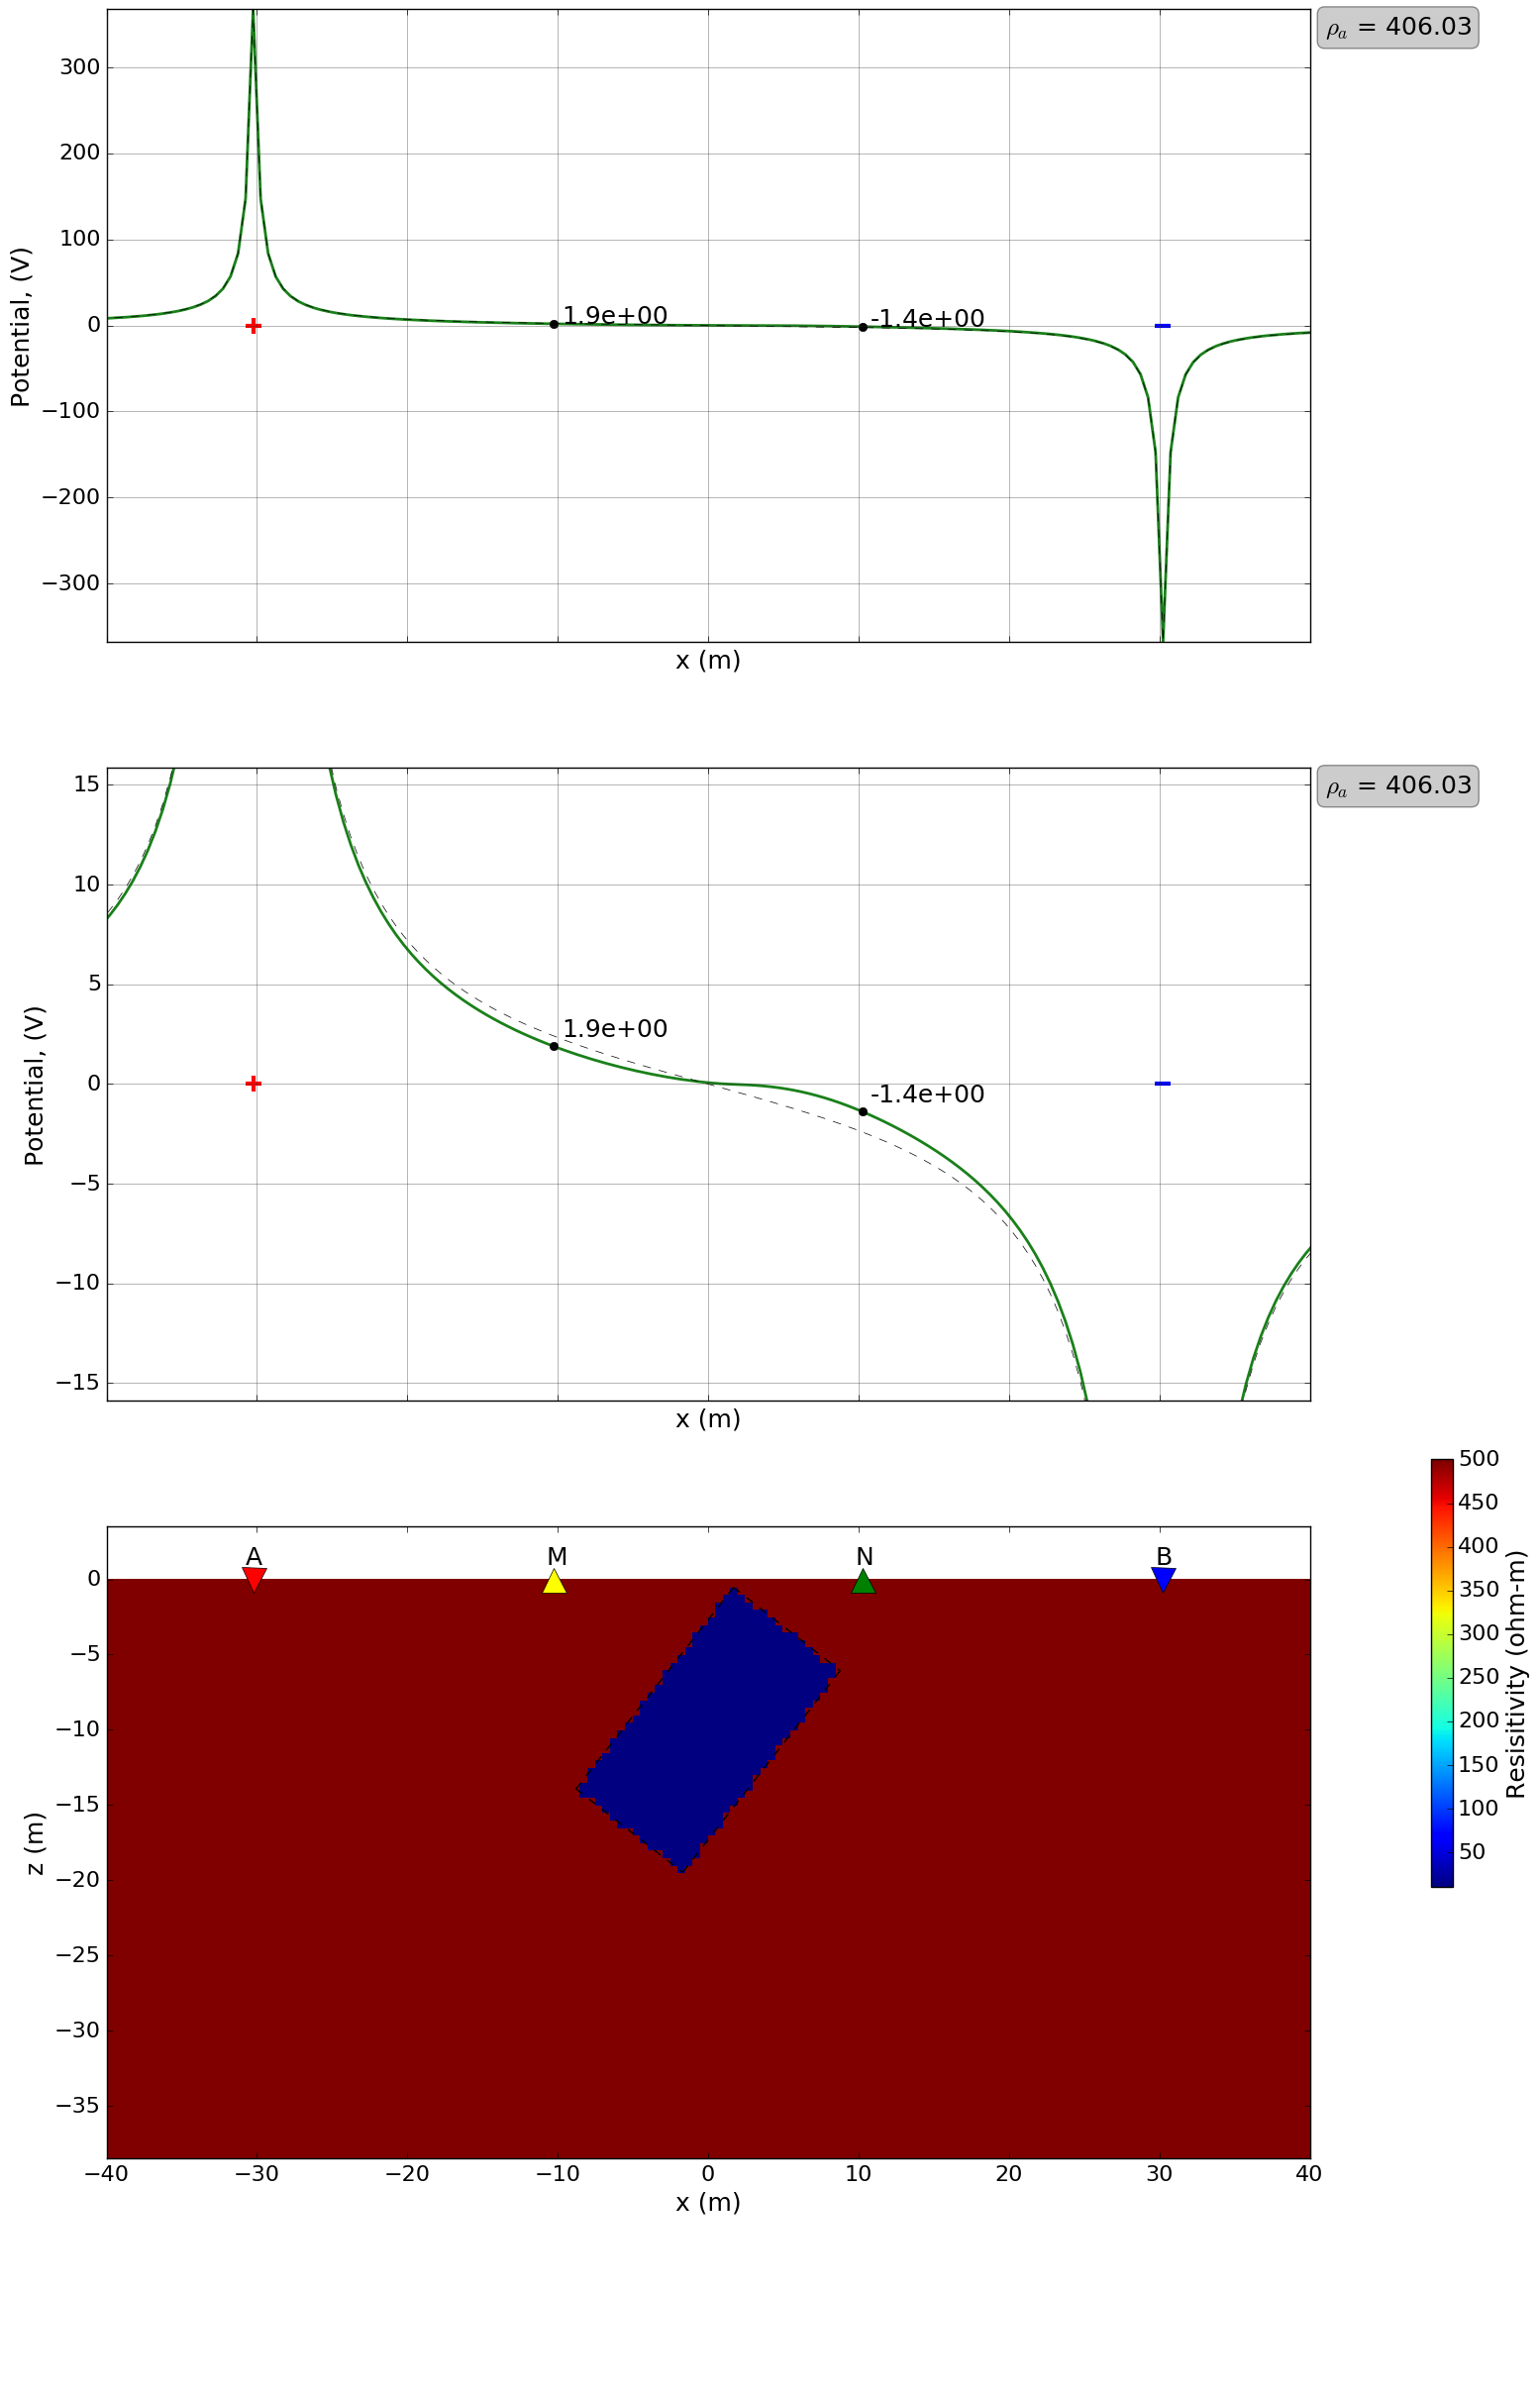

(<matplotlib.figure.Figure at 0x102c05310>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x102eb8290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10efc4810>], dtype=object))

In [3]:
app = plot_Surface_Potentials_app()
app;

In [8]:
xSurface = np.arange(-40.,41.,1.)
print xSurface
A = -30.
B = 30.

[-40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26.
 -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11.
 -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.
   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.
  35.  36.  37.  38.  39.  40.]


In [9]:
xSurface_AInd = np.where(np.abs(xSurface - A) >= 5.)[0]
print xSurface_AInd
xSurface_BInd = np.where(np.abs(xSurface - B) >= 5.)[0]
print xSurface_BInd

[ 0  1  2  3  4  5 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 75 76 77 78 79 80]


In [10]:
xSurfaceTxGapInd = list(set(xSurface_AInd).intersection(xSurface_BInd))

In [11]:
xSurfaceTxGapInd

[0,
 1,
 2,
 3,
 4,
 5,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 75,
 76,
 77,
 78,
 79,
 80]